В этом ноутбуке исследуется применимость bag of words подхода

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.model_selection  import GroupKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import gensim

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Чтение данных

In [2]:
true_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_true"))
false_files = filter(lambda x: x.endswith(".wav"), os.listdir("ibs_false"))

In [3]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

In [4]:
def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        a = read_frame(directory, i)
        frames.append([a, patient])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

In [5]:
true_frames = get_frames("ibs_true", true_files)
false_frames = get_frames("ibs_false", false_files)

In [6]:
def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs})
    return df

In [7]:
a = create_data_frame(true_frames, True)
b = create_data_frame(false_frames, False)

In [8]:
df = a.append(b).copy()

In [9]:
del a
del b

In [10]:
df = shuffle(df, random_state=27)
df = df.reset_index()

In [11]:
df["SignalLen"] = df["S"].apply(lambda x: len(x))
df = df[df["SignalLen"] != 0].copy()

In [12]:
import pywt as pw
from scipy import stats as ss

Стандартизация сигнала

In [13]:
df["SS"] = df["S"].apply(lambda x: ss.zscore(x))

Аппроксимирующие коэффициенты вейвлет-разложения

In [14]:
df["WSS"] = df["SS"].apply(lambda x: pw.dwt(x, 'db3')[0])

In [15]:
df.drop("SS", axis=1, inplace=True)

Параметры для построения признакового пространства. 

In [276]:
WINDOW_SIZE = 100
STEP = 30
WORDS_NUMBER = 200#число кластеров

Составление признакового пространства

Кластеризация локальных сегментов. 

Составление текста для каждого из сигналов.

Признаки: мешок слов, tf_idf

In [16]:
def get_text(result, local_segments_numbers):
    texts = []
    ind = 0
    for i in local_segments_numbers: 
        texts.append(result[ind:ind+i].copy())
        ind += i
    return texts

In [17]:
def create_features(train_data, test_data):
    train_data = train_data.copy()
    test_data = test_data.copy()
    train_m = train_data["local_segments"].as_matrix()
    test_m = test_data["local_segments"].as_matrix()
    train_segments = np.array(list(chain.from_iterable(train_m)))
    test_segments = np.array(list(chain.from_iterable(test_m)))
    kmeans = MiniBatchKMeans(n_clusters=WORDS_NUMBER, random_state=0)
    train_result = kmeans.fit_predict(train_segments)
    print "train_ready"
    test_result = kmeans.predict(test_segments)
    print "test_ready"
    
    train_data["texts"] = pd.Series(get_text(train_result, train_data["local_segments_len"]))
    test_data["texts"] = pd.Series(get_text(test_result, test_data["local_segments_len"]))
    
    train_data["texts"] =  train_data["texts"].apply(lambda x: " ".join(["ab" + str(i) for i in x]))
    test_data["texts"] =  test_data["texts"].apply(lambda x: " ".join(["ab" + str(i) for i in x]))
    

    bv = CountVectorizer(min_df=0)
    bv_train_data = bv.fit_transform(train_data["texts"])
    bv_test_data = bv.transform(test_data["texts"])
    
    tfidf = TfidfVectorizer(min_df=0)
    tf_train_data = tfidf.fit_transform(train_data["texts"])
    tf_test_data = tfidf.transform(test_data["texts"])
    return train_data, test_data, bv_train_data, bv_test_data, tf_train_data, tf_test_data

Разделение данных на k фолдов

In [18]:
def cv_tt(df, target, cv):
    df = df.copy()
    tt = []
    data = df.drop(target, axis = 1)
    y = df[target]
    i = 0
    for itrain, itest in cv:
        train_data = data.loc[itrain,:]
        test_data = data.loc[itest,:]
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        train_data, test_data, bv_train_data,\
        bv_test_data, tf_train_data, tf_test_data = create_features(train_data, test_data)
        fold = {"xtrain" : train_data, "b_train" : bv_train_data.todense().astype('float'), "t_train": tf_train_data.todense().astype('float'), "ytrain" : y[itrain], 
                "xtest" : test_data, "b_test" : bv_test_data.todense().astype('float'), "t_test": tf_test_data.todense().astype('float'), "ytest" : y[itest]}
        tt.append(fold)
        print "it =", i
        i+=1;
    return tt

Разбиение сигнала на локальные сегменты

In [21]:
def get_local_segments(a, b):
    return [a[i:i+WINDOW_SIZE].copy() for i in xrange(0, b, STEP)]

df["SignalLenW"] = df["WSS"].apply(lambda x: len(x) - WINDOW_SIZE)
df["local_segments"] = df[["WSS", "SignalLenW"]].apply(lambda x: get_local_segments(x[0], x[1]), axis=1)
df["local_segments_len"] = df["local_segments"].apply(lambda x: len(x))

In [22]:
df.reset_index(inplace=True)
df.drop(["index"], inplace=True, axis=1)

group_kfold = GroupKFold(n_splits=10)
cv = list(group_kfold.split(df, df["ibs"], df["Patient"]))

In [23]:
tt = cv_tt(df, "ibs", cv)

ok
(2375,)
10457813
here
train_ready
test_ready
it = 0
ok
(2629,)
11696864
here
train_ready
test_ready
it = 1
ok
(2784,)
12297396
here
train_ready
test_ready
it = 2
ok
(2784,)
12317159
here
train_ready
test_ready
it = 3
ok
(2784,)
12509341
here
train_ready
test_ready
it = 4
ok
(2784,)
12428469
here
train_ready
test_ready
it = 5
ok
(2784,)
12305772
here
train_ready
test_ready
it = 6
ok
(2785,)
12446071
here
train_ready
test_ready
it = 7
ok
(2785,)
12331047
here
train_ready
test_ready
it = 8
ok
(2785,)
12509890
here
train_ready
test_ready
it = 9


In [24]:
from copy import copy

Построение вектора текста с помощью word2vec. Объединение признаков.

In [26]:
def get_v(model, x):
    x = x.split()
    s = np.zeros(model.vector_size)
    for i in x:
        s += model[i]
    s *= 1.0/len(x)
    return s

def get_m(v):
    m = []
    for x in v:
        m.append(x)
    m = np.array(m)
    return m

def get_w2v_f(tt):
    tt = copy(tt)
    for i in range(len(tt)):
        s = tt[i]["xtrain"]["texts"].copy()
        s = s.apply(lambda x: x.split())
        model = gensim.models.Word2Vec(s, min_count=1, size=300)
        tt[i]["xtrain"]["v"] = tt[i]["xtrain"]["texts"].apply(lambda x: get_v(model, x))
        tt[i]["xtest"]["v"] = tt[i]["xtest"]["texts"].apply(lambda x: get_v(model, x))
        w_train = get_m(tt[i]["xtrain"]["v"])
        w_test = get_m(tt[i]["xtest"]["v"])
        tt[i]["w_train"] = w_train
        tt[i]["w_test"] = w_test
    return tt

In [27]:
def join_data(tt):
    tt = copy(tt)
    for i in range(len(tt)):
        tt[i]["bw_train"] = np.hstack((tt[i]["w_train"],tt[i]["b_train"]))
        tt[i]["bw_test"] = np.hstack((tt[i]["w_test"],tt[i]["b_test"]))
        tt[i]["tw_train"] = np.hstack((tt[i]["w_train"],tt[i]["t_train"]))
        tt[i]["tw_test"] = np.hstack((tt[i]["w_test"],tt[i]["t_test"]))
    return tt

In [131]:
tt_n = get_w2v_f(tt)

In [132]:
tt_full = join_data(tt_n)

Вспомогательные функции для обучения классификатора

In [29]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tr, pr_tr, p_tst, pr_tst

In [30]:
def cv_fit_predict(clf, cv_tt, tr_d, tst_d, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold[tr_d], fold["ytrain"], 
                                      fold[tst_d], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

Оценка результатов

In [32]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [67]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

Лог регрессия на мешке слов

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


roc-auc = 0.826140128401
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.730122071923
Качество по людям = 0.732818300492
Наилучшее разбиение происходит при границе 0.59
Качество по сигналам = 0.75783569779
Качество по людям = 0.746821333415


0.74682133341453993

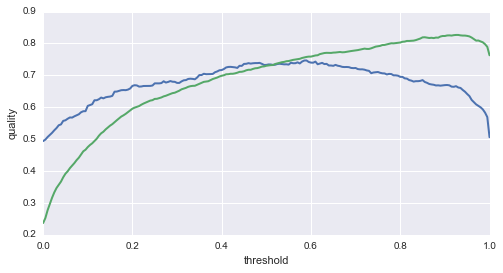

In [280]:
lrclf_params = {"C": 0.06, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l2"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, "b_train", "b_test", lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, df.shape[0])
review(df, lr_p, lr_pr, "ibs")

Лог регрессия на мешке слов + word2vec

100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


roc-auc = 0.835785863359
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.731441768393
Качество по людям = 0.737089540869
Наилучшее разбиение происходит при границе 0.57
Качество по сигналам = 0.760805014847
Качество по людям = 0.753091474359


0.75309147435913759

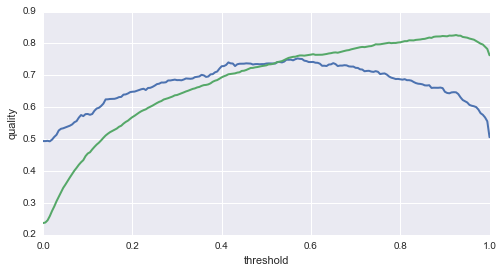

In [241]:
lrclf_params = {"C": 0.019, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l2"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, "bw_train", "bw_test", lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, df.shape[0])
review(df, lr_p, lr_pr, "ibs")

In [259]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

Xgboost на мешке слов плюс word2vec

In [270]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":8, "learning_rate":0.07,
                 "n_estimators": 200, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"error", "early_stopping_rounds":90000, "verbose":True}
xgb_res = cv_fit_predict(xgb.XGBClassifier, tt, "bw_train", "bw_test", xgbclf_params, xgbfit_params, do_scaling = False, xgbfit = True)
xgb_a, xgb_pr = combine_results(xgb_res, cv,  df.shape[0])

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-error:0.099368	validation_1-error:0.091463
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.090947	validation_1-error:0.10061
[2]	validation_0-error:0.080842	validation_1-error:0.083841
[3]	validation_0-error:0.066947	validation_1-error:0.091463
[4]	validation_0-error:0.058526	validation_1-error:0.099085
[5]	validation_0-error:0.058105	validation_1-error:0.112805
[6]	validation_0-error:0.055579	validation_1-error:0.108232
[7]	validation_0-error:0.057263	validation_1-error:0.126524
[8]	validation_0-error:0.052632	validation_1-error:0.13872
[9]	validation_0-error:0.049684	validation_1-error:0.152439
[10]	validation_0-error:0.047158	validation_1-error:0.160061
[11]	validation_0-error:0.044632	validation_1-error:0.150915
[12]	validation_0-error:0.040421	validation_1-error:0.144817
[13]	validation_0-error:0.039158	validation_1-error:0.1

 10%|█         | 1/10 [00:16<02:24, 16.02s/it]

[0]	validation_0-error:0.09167	validation_1-error:0.60199
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.067706	validation_1-error:0.584577
[2]	validation_0-error:0.068087	validation_1-error:0.577114
[3]	validation_0-error:0.058197	validation_1-error:0.569652
[4]	validation_0-error:0.055915	validation_1-error:0.559702
[5]	validation_0-error:0.049448	validation_1-error:0.549751
[6]	validation_0-error:0.046405	validation_1-error:0.544776
[7]	validation_0-error:0.044504	validation_1-error:0.544776
[8]	validation_0-error:0.04108	validation_1-error:0.542289
[9]	validation_0-error:0.038798	validation_1-error:0.542289
[10]	validation_0-error:0.036896	validation_1-error:0.539801
[11]	validation_0-error:0.033092	validation_1-error:0.532338
[12]	validation_0-error:0.033853	validation_1-error:0.539801
[13]	validation_0-error:0.03081	validation_1-error:0.537

 20%|██        | 2/10 [00:32<02:09, 16.20s/it]

[0]	validation_0-error:0.091236	validation_1-error:0.08502
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.065374	validation_1-error:0.080972
[2]	validation_0-error:0.05783	validation_1-error:0.08502
[3]	validation_0-error:0.055675	validation_1-error:0.076923
[4]	validation_0-error:0.048132	validation_1-error:0.076923
[5]	validation_0-error:0.048491	validation_1-error:0.072874
[6]	validation_0-error:0.04454	validation_1-error:0.076923
[7]	validation_0-error:0.040589	validation_1-error:0.076923
[8]	validation_0-error:0.036638	validation_1-error:0.076923
[9]	validation_0-error:0.034483	validation_1-error:0.060729
[10]	validation_0-error:0.031968	validation_1-error:0.060729
[11]	validation_0-error:0.031968	validation_1-error:0.060729
[12]	validation_0-error:0.032328	validation_1-error:0.05668
[13]	validation_0-error:0.028736	validation_1-error:0.0607

 30%|███       | 3/10 [00:52<02:00, 17.18s/it]

[0]	validation_0-error:0.095546	validation_1-error:0.255061
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.068247	validation_1-error:0.198381
[2]	validation_0-error:0.064655	validation_1-error:0.178138
[3]	validation_0-error:0.054239	validation_1-error:0.161943
[4]	validation_0-error:0.061422	validation_1-error:0.226721
[5]	validation_0-error:0.056034	validation_1-error:0.226721
[6]	validation_0-error:0.053879	validation_1-error:0.214575
[7]	validation_0-error:0.050647	validation_1-error:0.226721
[8]	validation_0-error:0.047055	validation_1-error:0.210526
[9]	validation_0-error:0.046695	validation_1-error:0.182186
[10]	validation_0-error:0.043822	validation_1-error:0.178138
[11]	validation_0-error:0.044181	validation_1-error:0.174089
[12]	validation_0-error:0.043463	validation_1-error:0.157895
[13]	validation_0-error:0.039511	validation_1-error:0

 40%|████      | 4/10 [01:09<01:44, 17.39s/it]

[0]	validation_0-error:0.092313	validation_1-error:0.161943
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.078305	validation_1-error:0.17004
[2]	validation_0-error:0.068606	validation_1-error:0.133603
[3]	validation_0-error:0.071121	validation_1-error:0.133603
[4]	validation_0-error:0.064296	validation_1-error:0.1417
[5]	validation_0-error:0.051365	validation_1-error:0.145749
[6]	validation_0-error:0.051006	validation_1-error:0.149798
[7]	validation_0-error:0.045259	validation_1-error:0.161943
[8]	validation_0-error:0.040948	validation_1-error:0.161943
[9]	validation_0-error:0.038793	validation_1-error:0.157895
[10]	validation_0-error:0.039511	validation_1-error:0.157895
[11]	validation_0-error:0.038075	validation_1-error:0.161943
[12]	validation_0-error:0.037716	validation_1-error:0.157895
[13]	validation_0-error:0.036638	validation_1-error:0.16

 50%|█████     | 5/10 [01:28<01:28, 17.63s/it]

[0]	validation_0-error:0.104167	validation_1-error:0.42915
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.094109	validation_1-error:0.368421
[2]	validation_0-error:0.098779	validation_1-error:0.364372
[3]	validation_0-error:0.086566	validation_1-error:0.360324
[4]	validation_0-error:0.080101	validation_1-error:0.311741
[5]	validation_0-error:0.07579	validation_1-error:0.331984
[6]	validation_0-error:0.077586	validation_1-error:0.323887
[7]	validation_0-error:0.073635	validation_1-error:0.34413
[8]	validation_0-error:0.06717	validation_1-error:0.327935
[9]	validation_0-error:0.063218	validation_1-error:0.34413
[10]	validation_0-error:0.059986	validation_1-error:0.331984
[11]	validation_0-error:0.061422	validation_1-error:0.331984
[12]	validation_0-error:0.061063	validation_1-error:0.323887
[13]	validation_0-error:0.059267	validation_1-error:0.3319

 60%|██████    | 6/10 [01:46<01:10, 17.71s/it]

[0]	validation_0-error:0.086925	validation_1-error:0.376518
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.077945	validation_1-error:0.408907
[2]	validation_0-error:0.072198	validation_1-error:0.412955
[3]	validation_0-error:0.068606	validation_1-error:0.404858
[4]	validation_0-error:0.066092	validation_1-error:0.396761
[5]	validation_0-error:0.06681	validation_1-error:0.396761
[6]	validation_0-error:0.059267	validation_1-error:0.40081
[7]	validation_0-error:0.056394	validation_1-error:0.40081
[8]	validation_0-error:0.053161	validation_1-error:0.408907
[9]	validation_0-error:0.051365	validation_1-error:0.384615
[10]	validation_0-error:0.044181	validation_1-error:0.380567
[11]	validation_0-error:0.042744	validation_1-error:0.368421
[12]	validation_0-error:0.041307	validation_1-error:0.364372
[13]	validation_0-error:0.040589	validation_1-error:0.36

 70%|███████   | 7/10 [02:00<00:49, 16.66s/it]

[0]	validation_0-error:0.086535	validation_1-error:0.272358
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.072531	validation_1-error:0.268293
[2]	validation_0-error:0.058887	validation_1-error:0.304878
[3]	validation_0-error:0.048833	validation_1-error:0.252033
[4]	validation_0-error:0.048474	validation_1-error:0.235772
[5]	validation_0-error:0.045601	validation_1-error:0.231707
[6]	validation_0-error:0.04632	validation_1-error:0.239837
[7]	validation_0-error:0.041652	validation_1-error:0.235772
[8]	validation_0-error:0.040934	validation_1-error:0.247967
[9]	validation_0-error:0.039497	validation_1-error:0.247967
[10]	validation_0-error:0.037343	validation_1-error:0.247967
[11]	validation_0-error:0.035907	validation_1-error:0.252033
[12]	validation_0-error:0.033393	validation_1-error:0.256098
[13]	validation_0-error:0.032316	validation_1-error:0.

 80%|████████  | 8/10 [02:17<00:33, 16.88s/it]

[0]	validation_0-error:0.085817	validation_1-error:0.329268
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.078276	validation_1-error:0.317073
[2]	validation_0-error:0.062837	validation_1-error:0.276423
[3]	validation_0-error:0.061041	validation_1-error:0.264228
[4]	validation_0-error:0.055296	validation_1-error:0.284553
[5]	validation_0-error:0.056732	validation_1-error:0.280488
[6]	validation_0-error:0.052424	validation_1-error:0.296748
[7]	validation_0-error:0.049551	validation_1-error:0.292683
[8]	validation_0-error:0.041652	validation_1-error:0.296748
[9]	validation_0-error:0.042729	validation_1-error:0.284553
[10]	validation_0-error:0.040215	validation_1-error:0.284553
[11]	validation_0-error:0.039497	validation_1-error:0.268293
[12]	validation_0-error:0.037343	validation_1-error:0.264228
[13]	validation_0-error:0.035548	validation_1-error:0

 90%|█████████ | 9/10 [02:35<00:17, 17.12s/it]

[0]	validation_0-error:0.100898	validation_1-error:0.361789
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.07684	validation_1-error:0.288618
[2]	validation_0-error:0.066427	validation_1-error:0.300813
[3]	validation_0-error:0.063555	validation_1-error:0.321138
[4]	validation_0-error:0.061759	validation_1-error:0.321138
[5]	validation_0-error:0.056014	validation_1-error:0.333333
[6]	validation_0-error:0.051706	validation_1-error:0.333333
[7]	validation_0-error:0.04991	validation_1-error:0.321138
[8]	validation_0-error:0.047038	validation_1-error:0.333333
[9]	validation_0-error:0.043806	validation_1-error:0.321138
[10]	validation_0-error:0.040934	validation_1-error:0.333333
[11]	validation_0-error:0.037702	validation_1-error:0.325203
[12]	validation_0-error:0.034111	validation_1-error:0.313008
[13]	validation_0-error:0.034111	validation_1-error:0.3

100%|██████████| 10/10 [02:53<00:00, 17.32s/it]


roc-auc = 0.831854469168
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.793467502474
Качество по людям = 0.733188433055
Наилучшее разбиение происходит при границе 0.155
Качество по сигналам = 0.709336852524
Качество по людям = 0.760594090215


0.76059409021499813

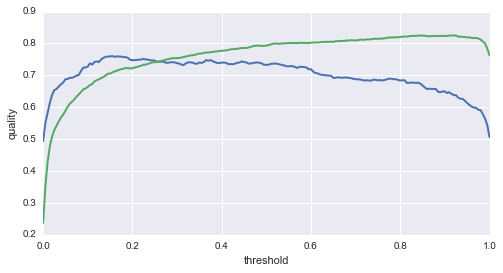

In [271]:
review(df, xgb_a, xgb_pr, "ibs")

In [272]:
def save_to_files(tt):
    for index, f in enumerate(tt):
        f["xtest"][["Patient", "texts"]].to_csv("Words_cv/xtest_cv"+str(index))
        f["xtrain"][["Patient", "texts"]].to_csv("Words_cv/xtrain_cv"+str(index))
        pd.DataFrame(f["b_test"]).to_csv("Words_cv/btest_cv"+str(index))
        pd.DataFrame(f["b_train"]).to_csv("Words_cv/btrain_cv"+str(index))
        pd.DataFrame(f["w_test"]).to_csv("Words_cv/wtest_cv"+str(index))
        pd.DataFrame(f["w_train"]).to_csv("Words_cv/wtrain_cv"+str(index))
        pd.DataFrame(f["bw_test"]).to_csv("Words_cv/bwtest_cv"+str(index))
        pd.DataFrame(f["bw_train"]).to_csv("Words_cv/bwtrain_cv"+str(index))

In [273]:
save_to_files(tt)